# First Practical Work

## Data Science and Engineering

### DESIGN OF AN IMAGE FILTER FUNCTION, PARALLELIZABLE AND SCALABLE

**Full name:** RAUL MALLO ALONSO
    
**NIA** : 100429745

In [1]:
import numpy as np
import multiprocessing as mp
from multiprocessing.sharedctypes import Array
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cProfile
import ctypes
import functions as my 

# Introduction #

The proposed assignment for the First Practical Work consists in the implementation of a filtermask to an image applying the tools provided by the multiprocessing library in function learned in class. 

Precisely, the procedure that will be followed throughout this assignment demonstrates that this features and tricks can be used in combination one with another to extract the best performance possible with the resources available. 

# Procedure # 

The first step will be to initialize two parallel processes running at the same time on the computer. Each one of the different processes will count with half the total computational capability of the computer, as the totallity of the cores will be splited in two, one half per process. 

Once each parallel process has been started, its goal is to implement the specified filter to the given image. This is done by using another one of the tools learned throughout the class, the multiprocessing Pool method. This method was created in order to optimize SIMD (single instruction, multiple data) operations within environments in theory though for working in series. This Pool method requires of several cores to be done, and will be in charge of applying the filter to several rows of the image simultaneously (one row each filter at one time).  

In order to securelly and optimally carrying out this assignment, apart from the ones specified other resources seen in class will be necessary, this is for example the case of the Shared Memory objects and utilities, such as global memories to ease the access to the information, o Locks, to avoid overridding problems when working with several processes in parallel. 

# Predefinition of the program code implementation # 

To carry out the task mentioned above, the first step is to define several variables and functions that are key for the program and will be used in the following.

In the first place, the image will be loaded from the repository into the program and then transformed into a numpy array in order to ease the process of working with it. By the structions given for the students, this image may have several layers (either one or three), which will be crucial to be taken into account later when defining the functions that will be used. 

In [2]:
F_IMAGE="chess.jpg"                        #<DEFINE HERE WHICH IMAGE YOU WANTS TO LOAD

In [ ]:
image= np.array(Image.open(F_IMAGE))

The next step is defining several filters to ensure that the algorithm implemented is valid and ensure that no subtle mistake or typo is impeding the code from working  properly. The first five filters (filter1-filter5) were given with the statement, however another two additional ones known as filter6 and filter7 were thought in order to be able to test at least one filter for each possible size of them.  

In [4]:
filter1=np.array([
    [0,0,0,0,0],
    [0,0,0,0,0],
    [0,0,1,0,0],
    [0,0,0,0,0],
    [0,0,0,0,0]
])
filter2=np.array([0.5, 0 , -0.5])
filter3=np.array([[0.5],[0],[0.5]])

filter4=np.array([
    [1,0,-1],
    [2,0,-2],
    [1,0,-1]
])
filter5=np.array([
    [0.00078633,0.00655965,0.01330373,0.00655965,0.00078633],
    [0.00655965,0.05472157,0.11098164,0.05472157,0.00655965],
    [0.01330373,0.11098164,0.22508352,0.11098164,0.01330373],
    [0.00655965,0.05472157,0.11098164,0.05472157,0.00655965],
    [0.00078633,0.00655965,0.01330373,0.00655965,0.00078633]
])

In [5]:
filter6=np.array([0.5, 0 ,0,0, -0.5])
filter7=np.array([[0.5],[0],[0],[0],[0.5]])

Also, in order to ease the process of working with shared memories and in order to be able to read them as general matrices and arrays, the function @tonumpyarray(mp_arr) is created. This function transforms the mp_arr parameter introduced as imput into an ordinary numpy array with the same dimensions as the parameter. 

In [6]:
def tonumpyarray(mp_arr):
    #mp_array is a shared memory array with lock
    
    return np.frombuffer(mp_arr.get_obj(),dtype=np.uint8)

Also, before starting with the different filter functions, it is neccessary to define and preallocate the shared memory objects that will store the rsult of the filtering process once it is finished. During its implementation, the different cores will write directly on them, and later they will be recalled into the main program to see the result of the computations. 

This shared arrays will be in the form of vectors, and will be able to contain as much information as the original image (same number of pixels) so that they are defined as follows: 

In [7]:
# first we need to obtain the total number of pixels that are stored in the image: 
data_buffer_size=image.shape[0]*image.shape[1]*image.shape[2]

# and then create two shared memory arrays with such size 
shared_space1= Array(ctypes.c_byte,data_buffer1_size)
shared_space2= Array(ctypes.c_byte,data_buffer1_size)

Notice that as two filters will be applied to the same image, and will give diffeent results, each one of them must be stored into its own shared space, otherwise the information of one (or both) of them would be lost or misunderstood. 

# Functions for the assignment # 

Once the general data has been set, it is neccessary to define the gross of the functions that will carry out the task explained before. All the functions that will be seen before (with the exception of @filters_execution( ... ) ) are defined in the 'functions.py' document attached in the folder, and will be called from there once they are needed. 

In the first place, it is the function @filters_execution. This is the first one to be called, and the outermost one, it means, the most global one.  It will open two different processes and perform one filter in each one of them. Furthermore, it will wait until both processes are finished before exiting the function, so no information is lost, or avoid leaving when any operation is not finished.

In [8]:
def filters_execution(image,filter1,filter2,numprocessors,shared_space1,shared_space2):
    '''
        This function will generate the two different processes that will be in charge of applying one different
        filter (specified in the parameters) each one of them. 

        :param image: the image that will be filtered as a numpy array (either bi or tridimensional)
        :param filter1: the first filter that will be applied to the image. Consists in a 2D numpy array.
        :param filter2: idem. but for the second filter implementation. Shall in theory be different from filter1. 
        :param numprocessors: integer that represents half the total number of cores (or the desired number of 
                              cores that will be available for each independent process)
        :param shared_space1:  the pre-initialization of the shared vector containing the result of the filter.
                                Shared Memory Array (vector) for the first filter application.
        :param shared_space1:  idem. for the second vector application. 

        :return: the result of this vector will be stored into the shared memory, so no output is needed to be 
                 specified.

        '''
    # creates a lock to handle memory access
    lock = mp.Lock()

    # define and start the processes
    p1 = mp.Process(target=my.image_filter,args=(image,filter1,numprocessors,shared_space1))
    p2 = mp.Process(target=my.image_filter,args=(image,filter2,numprocessors,shared_space2))

    p1.start()
    p2.start()

    # wait until the processes have ended
    p1.join()
    p2.join()

In the second place we can find the function @image_filter. This function is expected to be called twice, once by each filter, and will be the one implemented in parallel. It has to apply the desired filter to the given image by using the Pool method. Due to the fact that the filters have different dimentions, each one of them will have a different algorithm to be programmed, so the function @image_filter should also be able to define which is the most suitable function for the desired filter, and pass it as an input when calling the Pools. It works in the following way: 

In [ ]:
# Do not need to be defined, as it will not be called from here. 

def image_filter(p_image, p_filter, p_numprocessors, p_shared_space):
    '''
    This function will initilialize a pool which will run the chosen filter into the specified image.

    :param p_image: the image that will be filtered as a numpy array (either bi or tridimensional)
    :param p_filter: the filter that will be applied to the image. Consists in a 2D numpy array.
    :param p_numprocessors: the number of proccessor available to maximize the performance. Integer.
    :param p_shared_space:  the pre-initialization of the shared vector containing the result of the filter.
                            Shared memory vector.

    :return: the result of this vector will be stored into the shared memory, so no output is needed to be specified.

    '''
    # size contains the dimmensions of the filter been used -> determines the filter function being used
    size = p_filter.shape

    # Then the identification of the filter and its implementation is done. According to the nature of the filter, the
    # pool will be initialized with a different function which contains the different filters.

    rows = range(p_image.shape[0])

    if len(size) == 1:          # row-shaped filter
        with mp.Pool(processes=p_numprocessors, initializer=pool_init,
                     initargs=[p_shared_space, p_image, p_filter]) as p:
            p.map(rowed_filter, rows)
    elif size[0] > size[1]:     # column-shaped filter
        with mp.Pool(processes=p_numprocessors, initializer=pool_init,
                     initargs=[p_shared_space, p_image, p_filter]) as p:
            p.map(columned_filter, rows)
    else:                       # square-shaped filter
        with mp.Pool(processes=p_numprocessors, initializer=pool_init,
                     initargs=[p_shared_space, p_image, p_filter]) as p:
            p.map(squared_filter, rows)

In order to properly work within the Pool modules, an additional function was used in order to define all the needed global variables, which were introduced into image_filter as parameters, but would not do so inside the Pool. This function, called @pool_init( ... ) consists in the following: 

In [ ]:
# Do not need to be defined, as it will not be called from here. 

def pool_init(shared_array_, srcimg, imgfilter):
    '''
    This function initializes the global shared memory data whithin each Pool environment. 

    :param shared_array_: is the shared read/write data, with lock. It is a vector (because the shared
                          memory should be allocated as a vector
    :param srcimg: is the original image
    :param imgfilter: is the filter which will be applied to the image and store the results in the shared memory array

    :return: It will initialize all the required shared variables, including shared_matrix, were the results of the
             different rows being filtered will be stored
    '''

    # We define the local process memory reference for shared memory space
    global shared_space
    # Here we define the numpy matrix handler
    global shared_matrix

    # Here, we will define the readonly memory data as global (the scope of this global variables
    # is the local module)
    global image
    global my_filter

    # here, we initialize the global read only memory data
    image = srcimg
    my_filter = imgfilter
    size = image.shape

    # Assign the shared memory  to the local reference
    shared_space = shared_array_
    # Defines the numpy matrix reference to handle data, which will uses the shared memory buffer
    shared_matrix = tonumpyarray(shared_space).reshape(size)


Next, a simple function for the dot product was created, as it was considered useful for the following computations.

In [ ]:
# Do not need to be defined, as it will not be called from here. 

def dp(x, y):
    '''
    This functions computes the dot product between two vectors (they MUST be the same length)

    :param x: the first one of the vectors
    :param y: second vector

    :return: dot product of them both (float)
    '''
    r = 0
    for i in range(len(x)):
        r += float(x[i] * y[i])
    return r

# AFTER THIS CELL YOU HAVE TO WRITE YOUR CODE

After this cell you have to use the preloaded image defined in the F_IMAGE variable, select two of the 5 filter predefined, and using the NUMPROCESS processors, apply the filters to the image and check results.

* The first filter is impulse response filter (the image output must be equals to the original one).
* The second filter is an edge filter, first order in x axis,  
* The third filter is an edge filter, first order in y axis,
* the fourth filter is an edge filter, second order, bi-directional
* the fifth filter is a blur gausian filter.

Just for me to try Andy, I will check if the code works with the images chess and digits (smaller ones), that will be included in this repository, and the different filters to see if everything is okay or not. 

In [9]:
numprocessors= int(mp.cpu_count()/2)
print(numprocessors)
filters_execution(image1,filter1,filter2,numprocessors,shared_space1,shared_space2)

4


# Visualization
In this last cells we take the filtered images stored in the multiprocessing.Vector variables filtered_image1_VECTOR and filtered_image2_VECTOR, converts to numpy array, with the same shape of the orginal images, and show the results.

In [10]:
filtered_image1=tonumpyarray(shared_space1).reshape(image1.shape)
filtered_image2=tonumpyarray(shared_space2).reshape(image2.shape)

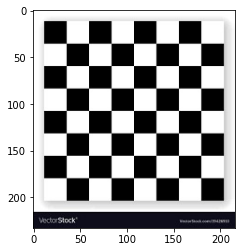

In [11]:
plt.figure()
plt.imshow(filtered_image1)

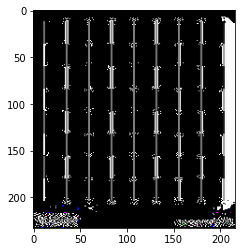

In [12]:
plt.figure()
plt.imshow(filtered_image2)